In [1]:
import numpy as np
from modules.utils import plot_disp_curves,plot_fv_map
from evodcinv import EarthModel, Layer, Curve
from disba import PhaseDispersion, GroupDispersion, PhaseSensitivity
from collections import namedtuple
import matplotlib.pylab as plt
import pickle
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
from disba import Ellipticity, depthplot, resample, surf96

from disba._common import ifunc
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import Normalize
from joblib import Parallel, delayed


cmap = cm.get_cmap('gnuplot2')
cmap = ListedColormap(cmap(np.linspace(0.1, 0.9, 256)))

cmap = cm.get_cmap('gray')
cmap = ListedColormap(cmap(np.linspace(0, 0.9, 256)))

In [1242]:
def plot_predicted_curve(inv_result, period, mode, wave, type, show="best", stride=1, percent=10, 
                         plot_args=None, ax=None):
    
    if type not in {"phase", "group", "ellipticity"}:
        raise ValueError()
    
    # Default parameters
    n_jobs = 1
    dc = 0.001
    dt = 0.01
    itype = {"phase": 0, "group": 1}
    units = {"frequency": "Hz", "period": "s"}
    
    # Model dispersion curves
    def get_y(thickness, velocity_p, velocity_s, density):
        c = surf96(period, thickness, velocity_p, velocity_s, density, mode, 
                   itype[type], ifunc["dunkin"][wave], dc, dt)
        idx = c > 0.0
        return c[idx]
    
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"type": "line", "xaxis": "period", "yaxis": "velocity", "cmap": "Oranges_r"}
    _plot_args.update(plot_args)

    plot_type = _plot_args.pop("type")
    xaxis = _plot_args.pop("xaxis")
    yaxis = _plot_args.pop("yaxis")
    cmap = _plot_args.pop("cmap")
    
    plot_type = plot_type if plot_type != "line" else "plot"
    plot = getattr(plt if ax is None else ax, plot_type)
    x = 1.0 / period if xaxis == "frequency" else period
    
    if show == 'percentage':
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[n_select::-stride]
        misfits = misfits[n_select::-stride]
        print('Plot curves from %d models.' %misfits.shape[0])

        # Make colormap
        norm = Normalize(misfits.min(), misfits.max())
        smap = ScalarMappable(norm, cmap)
        smap.set_array([])

        # Generate and plot curves
        curves = Parallel(n_jobs=n_jobs)(delayed(get_y)(*model.T) for model in models)
        for curve, misfit in zip(curves, misfits):
            y = (1.0 / curve if yaxis == "slowness" else curve*1e3)
            plot(x[: len(y)], y, color=smap.to_rgba(misfit), **_plot_args)

    elif show == "best":
        curve = get_y(*inv_result.model.T)
        y = y = (1.0 / curve if yaxis == "slowness" else curve*1e3)
        plot(x[: len(y)], y, **_plot_args, color='k')
        
    # Customize axes
    gca = ax if ax is not None else plt.gca()

    xlabel = f"{xaxis.capitalize()} [{units[xaxis]}]"
    ylabel = f"{type.capitalize()} "
    ylabel += f"{yaxis} [m/s]"
    gca.set_xlabel(xlabel)
    gca.set_ylabel(ylabel)

    # Disable exponential tick labels
    gca.xaxis.set_major_formatter(ScalarFormatter())
    gca.xaxis.set_minor_formatter(ScalarFormatter())
    
    
def plot_model(inv_result, parameter, show="best", stride=1, percent=10, zmax=None, 
               plot_args=None, ax=None, cmap_on=False, cmap_args=None, cmap_range=None):
    
    parameters = {
            "velocity_p": 1,
            "velocity_s": 2,
            "density": 3,
            "vp": 1,
            "vs": 2,
            "rho": 3,
    }
    
    if parameter not in parameters:
        raise ValueError()
    i_param = parameters[parameter]
        
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"cmap": "gist_ncar", "color": "black", "linewidth": 2}
    _plot_args.update(plot_args)

    cmap = _plot_args.pop("cmap")
    
    if show == 'percentage':
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[n_select::-stride]
        misfits = misfits[n_select::-stride]
        print('Plot %d models.' %misfits.shape[0])

        # Make colormap
        if cmap_range is None:
            norm = Normalize(misfits.min(), misfits.max())
        else:
            norm = Normalize(cmap_range[0], cmap_range[1])
        smap = ScalarMappable(norm, cmap)
        smap.set_array([])

        # Plot models
        for model, misfit in zip(models, misfits):
            tmp = {k: v for k, v in _plot_args.items()}
            tmp["color"] = smap.to_rgba(misfit)
            depthplot(model[:, 0]*1e3, model[:, i_param]*1e3, zmax, plot_args=tmp, ax=ax)

    elif show == "best":
        model = inv_result.model
        depthplot(model[:, 0]*1e3, model[:, i_param]*1e3, zmax, plot_args=_plot_args, ax=ax)
        
    elif show == "mean":
        # Select top percentage models
        idx = np.argsort(inv_result.misfits)[:]
        models = inv_result.models[idx]
        misfits = inv_result.misfits[idx]
        
        n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
        models = models[:n_select+1]
        print('Plot mean of %d models.' %models.shape[0])
        print('Misfit range: %.4f, %.4f.' %(misfits[0], misfits[n_select+1]))
        
        # Plot mean model
        model_mean = np.squeeze(np.mean(models, axis=0))
        depthplot(model_mean[:, 0]*1e3, model_mean[:, i_param]*1e3, zmax, plot_args=_plot_args, ax=ax)
        
    # Customize axes
    gca = ax if ax is not None else plt.gca()
    labels = {
        "velocity_p": "P-wave velocity (m/s)",
        "velocity_s": "S-wave velocity (m/s)",
        "density": "Density ($kg/m^3$)",
        "vp": "$V_p$ (m/s)",
        "vs": "$V_s$ (m/s)",
        "rho": "$\\rho$ ($kg/m^3$)",
    }
    xlabel = labels[parameter]
    ylabel = "Depth (m)"
    gca.set_xlabel(xlabel,fontsize=12)
    gca.set_ylabel(ylabel,fontsize=12)
    
    # Colorbar
    if cmap_on:
        cmap_args = cmap_args if cmap_args is not None else {}
        _cmap_args = {"orientation": "vertical", "label": "Log Misfit"}
        _cmap_args.update(cmap_args)
        plt.colorbar(smap, **_cmap_args)
        
        
def plot_model_range(model, plot_args=None, ax=None):
    
    d1 = np.array([])
    vs1 = np.array([])
    d2 = np.array([])
    vs2 = np.array([])
    
    for layer in model.layers:
        d1 = np.append(d1, layer.thickness[1])
        vs1 = np.append(vs1, layer.velocity_s[0])
        d2 = np.append(d2, layer.thickness[0])
        vs2 = np.append(vs2, layer.velocity_s[1])
    
    # Plot arguments
    plot_args = plot_args if plot_args is not None else {}
    _plot_args = {"color": "m", "linewidth": 2}
    _plot_args.update(plot_args)
    
    d2[-1] = np.sum(d1) - np.sum(d2[:-1])
    depthplot(d1*1e3, vs1*1e3, None, plot_args=_plot_args, ax=ax)
    depthplot(d2*1e3, vs2*1e3, None, plot_args=_plot_args, ax=ax)
    

def model_param_range(inv_result, percent=30, stride=None, plot_nu=False):
    
    # Select top percentage models
    idx = np.argsort(inv_result.misfits)[:]
    models = inv_result.xs[idx]

    n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
    if stride is None:
        stride = int(n_select // 4)
    models = models[n_select::-stride]
    n_model = models.shape[0]
    print('Record %d models.' %n_model)
    
    # Model parameters
    n_layer = int((len(models[0])+1) // 3)
    h = np.percentile(models[:, :n_layer-1], [0,25,50,75,100], axis=0)
    vs = np.percentile(models[:, n_layer-1:2*n_layer-1], [0,25,50,75,100], axis=0)
    nu = np.percentile(models[:, 2*n_layer-1:], [0,25,50,75,100], axis=0)
    
    # Print 0, 25, 50, 75, 100 percentiles
    for i in range(n_layer):
        print('Layer %d' %i)
        if i < n_layer - 1:
            print('Thickness [km]: %.4f, %.4f, %.4f, %.4f %.4f' %(h[0,i], h[1,i], h[2,i], h[3,i], h[-1,i]))
        print('Vs [km/s]: %.4f, %.4f, %.4f, %.4f %.4f' %(vs[0,i], vs[1,i], vs[2,i], vs[3,i], vs[-1,i]))
        print('Nu: %.4f, %.4f, %.4f, %.4f %.4f' %(nu[0,i], nu[1,i], nu[2,i], nu[3,i], nu[-1,i]))
        print()

    if plot_nu:
        nu = models[n_select::-1, 2*n_layer-1:]
        for i in range(n_layer):
            plt.figure(figsize=(8,8))
            plt.hist(nu[:, i])
            plt.grid()
            plt.show()
        

def get_mean_model(inv_result, percent=30):
    
    # Select top percentage models
    idx = np.argsort(inv_result.misfits)[:]
    models = inv_result.models[idx]
    misfits = inv_result.misfits[idx]

    n_select = np.floor((percent/100)*idx.shape[0]).astype(int)
    models = models[:n_select+1]
    print('Get mean of %d models.' %models.shape[0])
    print('Misfit range: %.4f, %.4f.' %(misfits[0], misfits[n_select+1]))

    # Return mean model
    model_mean = np.squeeze(np.mean(models, axis=0))
    return model_mean

def plot_results(res,survey,model,savefig=None):
    param = 'vs'
    show = 'percentage'
    percent = 100
    stride = 100
    cmap_range = (0.5, 2) # (-0.2, 1.5), (0.8, 2)

    fig, ax = plt.subplots(figsize=(4.5,4))
    ax.grid()
    plot_model(res, param, show=show, stride=stride, percent=percent, 
               plot_args={"cmap":cmap, "linewidth":0.05}, ax=ax, 
               cmap_on=True, cmap_args={"label":"Log Misfit"}, cmap_range=cmap_range)
    plot_model(res, param, show='best', plot_args={"color":"blue", "linewidth":3, "linestyle":"--"})
    plot_model(res, param, show='mean', percent=30, plot_args={"color":"cyan", "linewidth":3, "linestyle":"--"})
    depthplot(survey[:, 0]*1e3, survey[:, 1]*1e3, plot_args={"color":"red", "linewidth":3, "linestyle":"--"})
    plot_model_range(model, ax=ax)
    # Legend
#     obj1, = ax.plot([-1, -2], [-1, -2], 'b--', linewidth=2, label='Best Model')
#     obj2, = ax.plot([-1, -2], [-1, -2], 'c--', linewidth=2, label='Mean of Top 30% Models')
#     obj3, = ax.plot([-1, -2], [-1, -2], 'r--', linewidth=2, label='Survey Model')
#     ax.legend(handles=[obj1, obj2,obj3], fontsize=12,
#               loc='upper right', bbox_to_anchor=(1, 0.9))

    ax.set_ylim([100, 0])
    ax.set_xlim([0, 1200])
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout(pad=1.0)
    if savefig:       
        plt.savefig(f'figures/{savefig}.svg')
    
def plot_fv_map_overlay(fv_map, freqs, vels, norm=True, ax=None, color='b', alpha=0.02,
                        pclip=100, fontsize=24, tickfont=20, ridge_data=None, freq_lb=None, freq_ub=None):
    if norm:         
        row_sums = np.amax(fv_map, axis=0)
        fv_map = fv_map / row_sums

    pclip = 98
    vmax = np.percentile(np.abs(fv_map), pclip)
    vmin = np.percentile(np.abs(fv_map), 100-pclip)
    cmap_range = (0.5, 2)
#     print(vmax, vmin)

    im = ax.imshow(fv_map, aspect="auto",
              extent=[freqs[0], freqs[-1], vels[0], vels[-1]],
              cmap="jet",
              vmax=vmax,
              vmin=vmin)
    
    if ridge_data:
        freq_ridge, vel_ridge = ridge_data     
        for i in range(len(vel_ridge)):
            freq = freqs[(freqs >= freq_lb[i]) & (freqs < freq_ub[i])]
            ridge_vel = np.array([d for d in vel_ridge[i]],dtype=np.float64)
            ridge_vel_mean = np.mean(vel_ridge[i],axis=0)
            ridge_std = np.asarray([np.std(vel_ridge[i],axis=0), np.std(vel_ridge[i],axis=0)])
            plt.errorbar(freq, ridge_vel_mean, yerr=ridge_std, fmt='-k', 
                         alpha=0.5, linewidth=2, markersize=5)
            
def plot_inversion_overlay(res,vels,picked_modes1,picked_modes2,fig_name):
    show = 'percentage'
    fig, ax = plt.subplots(figsize=(4.5,4))
    stride = 500
    percent= 70
    cmaps = ['Blues_r','Reds_r','Greys_r','Purples_r','Greens_r']
    flb = [[2.5,25],[5,25],[8,25],[12,25],[15,25]]
    for i in picked_modes1:
        plot_predicted_curve(res, np.linspace(1/flb[i][1], 1/flb[i][0], 100), i, 'rayleigh', 'phase',
                             show=show, percent=percent, ax=ax, stride=stride, 
                             plot_args={"xaxis": "frequency", "cmap":cmaps[i],"alpha":0.05})
    
    for i in picked_modes2:
        freq = freqs[(freqs >= freq_lb[i]) & (freqs < freq_ub[i])][::3]
        ridge_vel = vels[i]
        ridge_vel_mean = np.mean(ridge_vel,axis=0)[::3]
        ridge_std = np.asarray([np.std(ridge_vel,axis=0)[::3], np.std(ridge_vel,axis=0)[::3]])
        plt.errorbar(freq, ridge_vel_mean, yerr=ridge_std,
                     zorder=3, fmt='ro', markersize=3)

    ax.set_xlim([2, 25])
    ax.set_ylim([200, 800])
    ax.grid()    
    ax.set_ylabel('Phase Velocity (m/s)', fontsize=12)
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()
    plt.savefig(f'figures/{fig_name}.svg', format='svg')
    plt.show()


# Different weights

In [528]:
_x0 = 700
file_name = f'data/{_x0}_weights.npz'
data_weights = np.load(file_name,allow_pickle=True)

freqs = data_weights['freqs']
freq_lb = data_weights['freq_lb']
freq_ub = data_weights['freq_ub']
vels_heavy = data_weights['vels_heavy']
vels_mid = data_weights['vels_mid']
vels_light = data_weights['vels_light']

# vel_heavy_means, vel_heavy_ranges, vel_heavy_stds = plot_disp_curves(freqs,freq_lb,freq_ub,vels_heavy)
# vel_mid_means, vel_mid_ranges, vel_mid_stds = plot_disp_curves(freqs,freq_lb,freq_ub,vels_mid)
# vel_light_means, vel_light_ranges, vel_light_stds = plot_disp_curves(freqs,freq_lb,freq_ub,vels_light)

## Obtain dispersion curves

In [1225]:
periods0 = np.array(1/freqs[(freqs >= freq_lb[0]) & (freqs < freq_ub[0])])[::-1]
periods2 = np.array(1/freqs[(freqs >= freq_lb[2]) & (freqs < freq_ub[2])])[::-1]
periods3 = np.array(1/freqs[(freqs >= freq_lb[3]) & (freqs < freq_ub[3])])[::-1]

disp_curves_heavy = [Curve(periods0,vel_heavy_means[0][::-1]/1000,0,'rayleigh',
                           'phase',weight=2,uncertainties=vel_heavy_ranges[0][::-1]/1000),
                    Curve(periods2,vel_heavy_means[2][::-1]/1000,3,'rayleigh',
                           'phase',uncertainties=vel_heavy_ranges[2][::-1]/1000),
                    Curve(periods3,vel_heavy_means[3][::-1]/1000,4,'rayleigh',
                           'phase',uncertainties=vel_heavy_ranges[3][::-1]/1000)]

# disp_curves_heavy = [Curve(periods0,vel_heavy_means[0][::-1]/1000,0,'rayleigh',
#                            'phase',weight=10,uncertainties=vel_heavy_ranges[0][::-1]/1000)]

disp_curves_mid = [Curve(periods0,vel_mid_means[0][::-1]/1000,0,'rayleigh',
                         'phase',weight=2,uncertainties=vel_mid_ranges[0][::-1]/1000),
                    Curve(periods2,vel_mid_means[2][::-1]/1000,3,'rayleigh',
                           'phase',uncertainties=vel_mid_ranges[2][::-1]/1000),
                    Curve(periods3,vel_mid_means[3][::-1]/1000,4,'rayleigh',
                           'phase',uncertainties=vel_mid_ranges[3][::-1]/1000)]

disp_curves_light = [Curve(periods0,vel_light_means[0][::-1]/1000,0,'rayleigh',
                           'phase',weight=2,uncertainties=vel_light_ranges[0][::-1]/1000),
                    Curve(periods3,vel_light_means[3][::-1]/1000,4,'rayleigh',
                           'phase',uncertainties=vel_light_ranges[3][::-1]/1000)]

## Build earth model

In [1226]:
model = EarthModel()

# Build model search boundaries from top to bottom
# First argument is the bounds of layer's thickness [km]
# Second argument is the bounds of layer's S-wave velocity [km/s]
model.add(Layer([0.001, 0.01], [0.1, 0.5], [0.33,0.49]))
model.add(Layer([0.001, 0.01], [0.1, 0.5], [0.33,0.49]))
model.add(Layer([0.001, 0.01], [0.2, 0.6], [0.33,0.49]))
model.add(Layer([0.005, 0.025], [0.2, 0.6], [0.33,0.49]))
model.add(Layer([0.02, 0.08], [0.4, 1], [0.33,0.49]))
model.add(Layer([0.02, 0.08], [0.4, 1], [0.33,0.49]))

f_rho = lambda x: 1.56 + 0.186*x
# Configure model
model.configure(
    optimizer="cpso",  # Evolutionary algorithm
    misfit="rmse",  # Misfit function type
    density = f_rho,  # "nafe-drake"
    optimizer_args={
        "popsize": 50,  # Population size
        "maxiter": 1000,  # Number of iterations
        "workers": -1,  # Number of cores
        "seed": 0,
    },
)

model

--------------------------------------------------------------------------------
Earth model parameters

------------------------------------------------------------
              d [km]           vs [km/s]              nu [-]
       min       max       min       max       min       max
------------------------------------------------------------
    0.0010    0.0100    0.1000    0.5000    0.3300    0.4900
    0.0010    0.0100    0.1000    0.5000    0.3300    0.4900
    0.0010    0.0100    0.2000    0.6000    0.3300    0.4900
    0.0050    0.0250    0.2000    0.6000    0.3300    0.4900
    0.0200    0.0800    0.4000    1.0000    0.3300    0.4900
    0.0200    0.0800    0.4000    1.0000    0.3300    0.4900
------------------------------------------------------------

Number of layers: 6
Number of parameters: 18
--------------------------------------------------------------------------------

## Run inversion

In [1227]:
res_heavy = model.invert(disp_curves_heavy, maxrun=5)
res_mid = model.invert(disp_curves_mid, maxrun=5)
res_light = model.invert(disp_curves_light, maxrun=5)

Run 1   |████████████████████| 100% [0:03:20 / 0:00:00] - Misfit: 0.1211
Run 2   |████████████████████| 100% [0:03:18 / 0:00:00] - Misfit: 0.1212
Run 3   |████████████████████| 100% [0:03:51 / 0:00:00] - Misfit: 0.1181
Run 4   |████████████████████| 100% [0:03:21 / 0:00:00] - Misfit: 0.1183
Run 5   |████████████████████| 100% [0:03:41 / 0:00:00] - Misfit: 0.1164


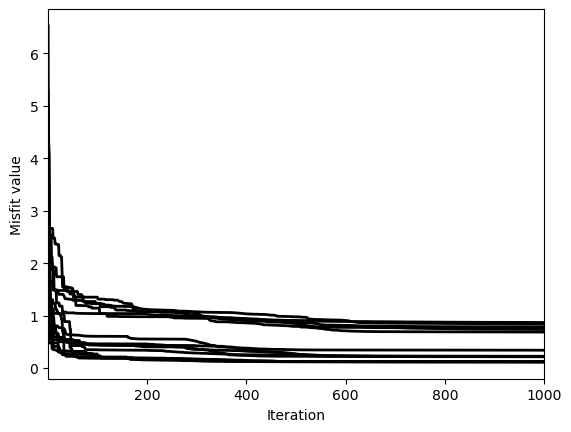

In [1228]:
res_heavy.plot_misfit()
res_mid.plot_misfit()
res_light.plot_misfit()

## Plot results

In [1229]:
# depth (km), Vs (km/s)
survey_data = np.array([0.0005*0.3048, 0.280*0.348,
                         0.001*0.3048, 0.610*0.348,
                         0.0015*0.3048, 0.7*0.348,
                         0.002*0.3048, 0.8*0.348,
                         0.005*0.3048, 0.966*0.348,
                         0.02*0.3048, 1.180*0.348,
                         0.02*0.3048, 1.562*0.348,
                         0.05*0.3048, 1.280*0.348,
                         0.14*0.3048, 1.520*0.348,
                         1*0.3048, 1.730*0.348,]).reshape(-1,2)

In [1230]:
with open('weight_inverson.pkl', 'wb') as f:
    pickle.dump([res_heavy,res_mid,res_light], f)
with open('weight_inverson.pkl', 'rb') as f:
    res_heavy,res_mid,res_light = pickle.load(f)

Plot 2500 models.
Plot mean of 75001 models.
Misfit range: 0.6856, 0.8840.
Plot 2500 models.
Plot mean of 75001 models.
Misfit range: 0.2155, 0.2509.
Plot 2500 models.
Plot mean of 75001 models.
Misfit range: 0.1164, 0.1235.


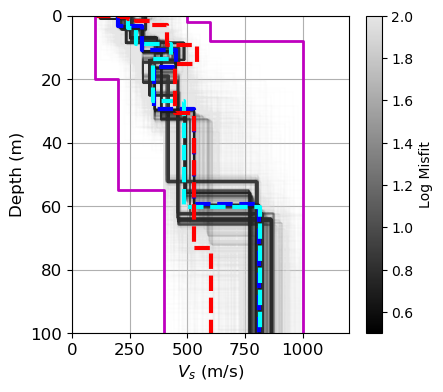

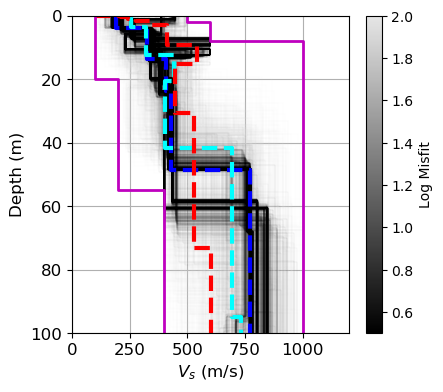

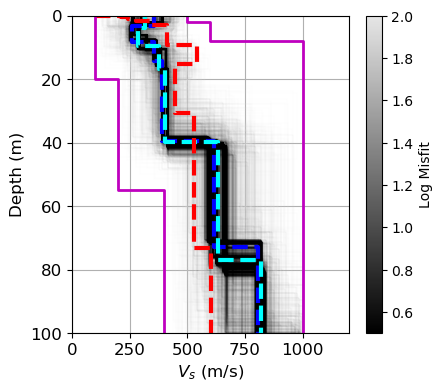

In [1239]:
plot_results(res_heavy,survey_data,model,savefig=f'{_x0}/heavy_inversion')
plot_results(res_mid,survey_data,model,savefig=f'{_x0}/midweight_inversion')
plot_results(res_light,survey_data,model,savefig=f'{_x0}/light_inversion')

Plot curves from 351 models.
Plot curves from 351 models.
Plot curves from 351 models.
Plot curves from 351 models.
Plot curves from 351 models.


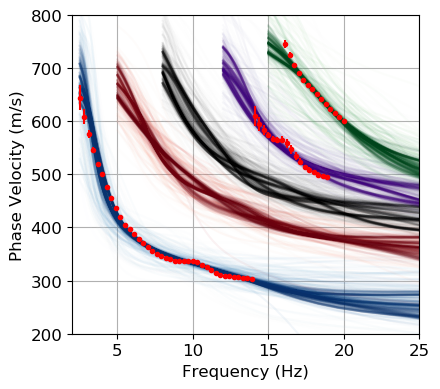

Plot curves from 351 models.
Plot curves from 351 models.
Plot curves from 351 models.
Plot curves from 351 models.
Plot curves from 351 models.


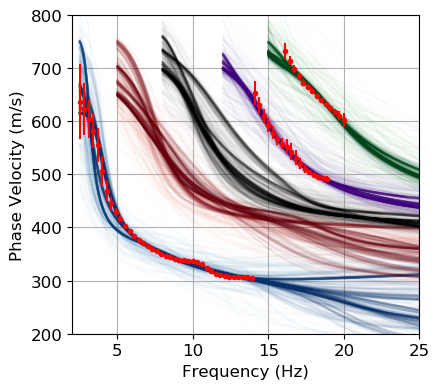

Plot curves from 351 models.
Plot curves from 351 models.
Plot curves from 351 models.
Plot curves from 351 models.
Plot curves from 351 models.


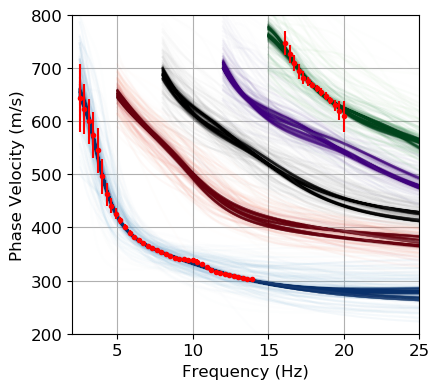

In [1243]:
plot_inversion_overlay(res_heavy,vels_heavy,[0,1,2,3,4],[0,2,3],f'{_x0}/inversion_comp_heavy')
plot_inversion_overlay(res_mid,vels_mid,[0,1,2,3,4],[0,2,3],f'{_x0}/inversion_comp_mid')
plot_inversion_overlay(res_light,vels_light,[0,1,2,3,4],[0,3],f'{_x0}/inversion_comp_light')

In [1166]:
res_heavy

--------------------------------------------------------------------------------
Best model out of 250000 models (5 runs)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    0.0033    1.4127    0.1978    1.8228              0.0033    0.1978    0.4900
    0.0077    0.8868    0.3015    1.7250              0.0077    0.3015    0.4347
    0.0053    0.8982    0.4520    1.7271              0.0053    0.4520    0.3304
    0.0133    1.9873    0.3568    1.9296              0.0133    0.3568    0.4833
    0.0299    1.0469    0.5273    1.7547              0.0299    0.5273    0.3300
    1.0000    1.6101    0.8110    1.8595                   -    0.8110    0.3300


In [13]:
res_heavy

--------------------------------------------------------------------------------
Best model out of 250000 models (5 runs)

Velocity model                                    Model parameters
----------------------------------------          ------------------------------
         d        vp        vs       rho                   d        vs        nu
      [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
----------------------------------------          ------------------------------
    0.0040    0.9457    0.4356    1.2022              0.0040    0.4356    0.3654
    0.0066    0.5878    0.2568    0.8265              0.0066    0.2568    0.3821
    0.0083    3.4150    0.4782    2.3040              0.0083    0.4782    0.4900
    0.0106    1.2599    0.3149    1.4673              0.0106    0.3149    0.4667
    0.0580    1.5981    0.5698    1.6960              0.0580    0.5698    0.4272
    1.0000    2.2006    0.7693    1.9891                   -    0.7693    0.4304


## Sensitivity kernel

In [1240]:
new_resolution = 0.01
max_value = 0.3
# Create the new first column
new_first_column = np.ones(int(max_value/new_resolution))*new_resolution

# Create the new array with interpolated values
res_heavy_model = np.zeros((new_first_column.size, res_heavy.model.shape[1]))
res_heavy_model[:, 0] = new_first_column

n = 0
for i in range(res_heavy.model.shape[0]):
    layer = np.round(res_heavy.model[i,0],3)
    res_heavy_model[n:n+int(layer/new_resolution), 1:] = res_heavy.model[i, 1:]
    n+=int(layer/new_resolution)
    
ps = PhaseSensitivity(*res_heavy_model.T)

parameters = ["velocity_s"]
freqs_ = [2,3,4,5,10,15,20,25]

skrs = []
for f in freqs_:
    t = 1/f
    skr = [ps(t, mode=0, wave="rayleigh", parameter=parameter) for parameter in parameters]
    skrs.append(skr)
    

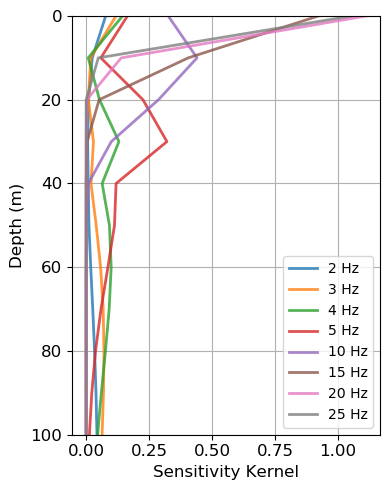

In [1241]:
plt.figure(figsize=(4, 5))

for i, skr in enumerate(skrs):
    for s in skr:
        s.kernel[-1:] = 0.0
        plt.plot(s.kernel, s.depth*1000, label = f"{freqs_[i]} Hz", linewidth=2.0, alpha=0.8)

# plt.xlim([-0.1, 0.5])
plt.ylim([0,100])
plt.xlabel('Sensitivity Kernel', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
# plt.legend()
plt.grid()
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=12)
# plt.title('Rayleigh-wave (Phase)', fontsize=12)
plt.tight_layout()
plt.savefig(f'figures/sensitivity.pdf', format='pdf')
plt.show()

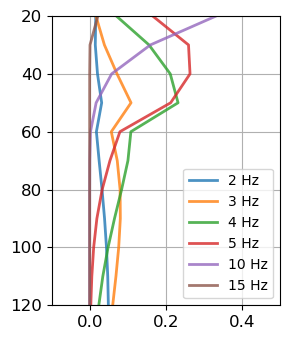

In [45]:
plt.figure(figsize=(3, 3.5))

for i, skr in enumerate(skrs):
    for s in skr:
        s.kernel[-1:] = 0.0
        plt.plot(s.kernel, s.depth*1000, label = f"{freqs[i]} Hz", linewidth=2.0, alpha=0.8)

plt.xlim([-0.1, 0.5])
plt.ylim([20,120])
# plt.xlabel('Sensitivity Kernel', fontsize=12)
# plt.ylabel('Depth (m)', fontsize=12)
plt.legend()
plt.grid()
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=12)
# plt.title('Rayleigh-wave (Phase)', fontsize=12)
plt.tight_layout()
plt.savefig(f'figures/sensitivity.pdf', format='pdf')
plt.show()

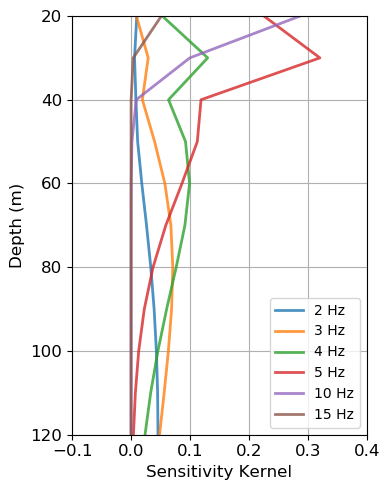

In [1184]:
plt.figure(figsize=(4, 5))

for i, skr in enumerate(skrs):
    for s in skr:
        s.kernel[-1:] = 0.0
        plt.plot(s.kernel, s.depth*1000, label = f"{freqs_[i]} Hz", linewidth=2.0, alpha=0.8)

plt.xlim([-0.1, 0.4])
plt.ylim([20,120])
plt.xlabel('Sensitivity Kernel', fontsize=12)
plt.ylabel('Depth (m)', fontsize=12)
plt.legend()
plt.grid()
plt.gca().invert_yaxis()
plt.tick_params(axis='both', which='major', labelsize=12)
# plt.title('Rayleigh-wave (Phase)', fontsize=12)
plt.tight_layout()
plt.savefig(f'figures/sensitivity_zoom.svg', format='svg')
plt.show()